# COVID-19 in Australia (from covidlive.com.au)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span><ul class="toc-item"><li><span><a href="#other-useful-information" data-toc-modified-id="other-useful-information-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>other useful information</a></span></li><li><span><a href="#get-the-data" data-toc-modified-id="get-the-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>get the data</a></span></li></ul></li><li><span><a href="#Total-Cases---weekly-charts" data-toc-modified-id="Total-Cases---weekly-charts-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Total Cases - weekly charts</a></span></li><li><span><a href="#Total-deaths---weekly-charts" data-toc-modified-id="Total-deaths---weekly-charts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Total deaths - weekly charts</a></span></li><li><span><a href="#Active-Cases" data-toc-modified-id="Active-Cases-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Active Cases</a></span></li><li><span><a href="#Source-of-infection" data-toc-modified-id="Source-of-infection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Source of infection</a></span></li><li><span><a href="#Local-cases---speculative" data-toc-modified-id="Local-cases---speculative-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Local cases - speculative</a></span><ul class="toc-item"><li><span><a href="#Calculate-and-plot-local-transmission-from-SOI-data" data-toc-modified-id="Calculate-and-plot-local-transmission-from-SOI-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Calculate and plot local transmission from SOI data</a></span></li><li><span><a href="#Historical-local-cases-charts" data-toc-modified-id="Historical-local-cases-charts-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Historical local cases charts</a></span></li><li><span><a href="#Check-consistency-between-cases-data-and-SOI-data" data-toc-modified-id="Check-consistency-between-cases-data-and-SOI-data-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Check consistency between cases data and SOI data</a></span></li></ul></li><li><span><a href="#Hospitalised" data-toc-modified-id="Hospitalised-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Hospitalised</a></span></li><li><span><a href="#Tests" data-toc-modified-id="Tests-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Tests</a></span></li><li><span><a href="#The-End" data-toc-modified-id="The-End-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python set-up

In [1]:
# imports
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.units as munits
import matplotlib.dates as mdates
import datetime

from pathlib import Path
from typing import Dict, List

#pandas
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# local imports
sys.path.append(r'../bin')
import plotstuff as ps

# plotting
plt.style.use('ggplot')
%matplotlib inline

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

### other useful information

In [2]:
# save location
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!AS-'

source = 'Source: https://covidlive.com.au/'

months = ['-', 'Jan', 'Feb', 'Mar', 'Apr',
               'May', 'Jun', 'Jul', 'Aug',
               'Sep', 'Oct', 'Nov', 'Dec',]

warning_count = 0

### get the data

In [3]:
def get_data_from_JSON():
    """Return a dictionary of dataframes, one dataframe for each state"""
    
    url = 'https://covidlive.com.au/covid-live.json'
    all_frame = pd.read_json(url)
    
    dic = {}
    states = all_frame.CODE.unique()
    for state in states:
        data = all_frame[all_frame.CODE == state].copy()
        data.index = pd.DatetimeIndex(data.REPORT_DATE)
        data = data.sort_index()
        dic[state] = data
    return dic, all_frame

dic_data, frame_data = get_data_from_JSON()

In [4]:
# check on latest data for each jurisdiction
report = pd.DataFrame()
for state in dic_data.keys():
    series = pd.Series([state, dic_data[state].index[-1].date(),
                        dic_data[state].iloc[-1].isna().sum(),
                        dic_data[state].iloc[-2].isna().sum()],
                        index=['State', 'Last date', 
                               'NANs on last day',
                               'NANs on second last day'])
    report[state] = series
report

,AUS,NSW,VIC,QLD,WA,SA,TAS,ACT,NT
State,AUS,NSW,VIC,QLD,WA,SA,TAS,ACT,NT
Last date,2021-01-05,2021-01-05,2021-01-05,2021-01-05,2021-01-05,2021-01-05,2021-01-05,2021-01-05,2021-01-05
NANs on last day,1,6,6,4,8,5,7,6,7
NANs on second last day,1,6,6,4,6,5,7,7,7


In [5]:
# a useful list of data items
frame_data.columns

Index(['REPORT_DATE', 'LAST_UPDATED_DATE', 'CODE', 'NAME', 'CASE_CNT',
       'TEST_CNT', 'DEATH_CNT', 'RECOV_CNT', 'MED_ICU_CNT', 'MED_VENT_CNT',
       'MED_HOSP_CNT', 'SRC_OVERSEAS_CNT', 'SRC_SHIP_CNT',
       'SRC_INTERSTATE_CNT', 'SRC_CONTACT_CNT', 'SRC_UNKNOWN_CNT',
       'SRC_INVES_CNT', 'PREV_CASE_CNT', 'PREV_TEST_CNT', 'PREV_DEATH_CNT',
       'PREV_RECOV_CNT', 'PREV_MED_ICU_CNT', 'PREV_MED_VENT_CNT',
       'PREV_MED_HOSP_CNT', 'PREV_SRC_OVERSEAS_CNT', 'PREV_SRC_SHIP_CNT',
       'PREV_SRC_INTERSTATE_CNT', 'PREV_SRC_CONTACT_CNT',
       'PREV_SRC_UNKNOWN_CNT', 'PREV_SRC_INVES_CNT', 'PROB_CASE_CNT',
       'PREV_PROB_CASE_CNT', 'ACTIVE_CNT', 'PREV_ACTIVE_CNT', 'NEW_CASE_CNT',
       'PREV_NEW_CASE_CNT'],
      dtype='object')

## Total Cases - weekly charts

In [6]:
cases_cum_u = frame_data.pivot(index='REPORT_DATE', columns='NAME', values='CASE_CNT')
cases_cum_u.index = pd.DatetimeIndex(cases_cum_u.index)
if cases_cum_u.iloc[-1].isna().any():
    cases_cum_u = cases_cum_u[:-1]
cases_daily_u, cases_daily_c, cases_cum_c = (
    ps.dataframe_correction(cases_cum_u, verbose=False))

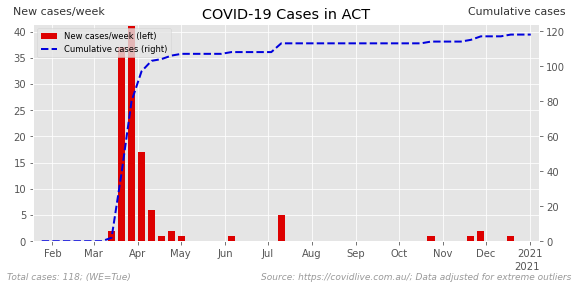

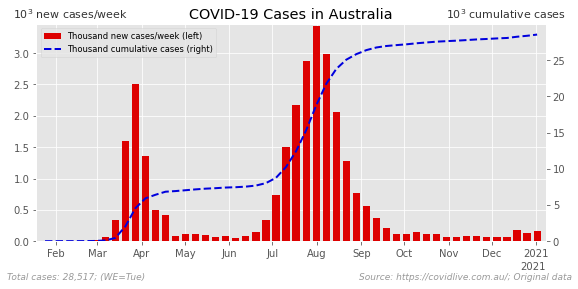

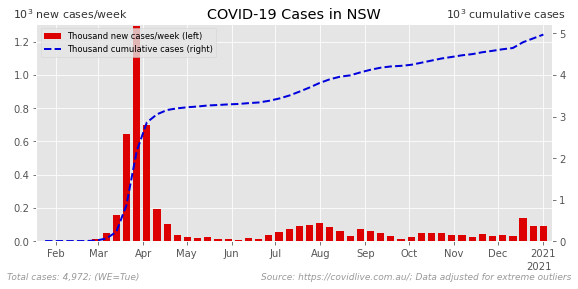

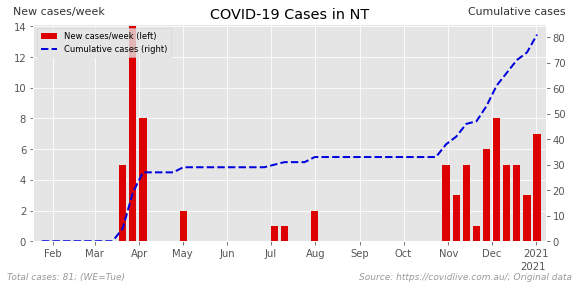

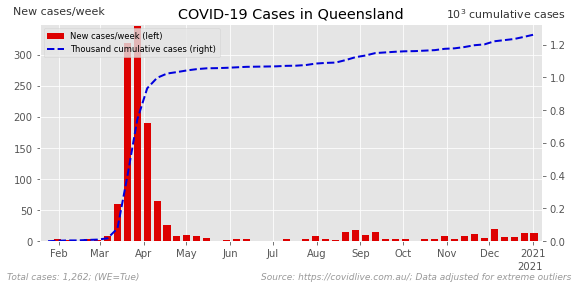

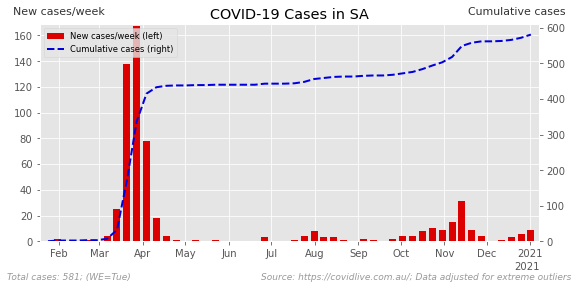

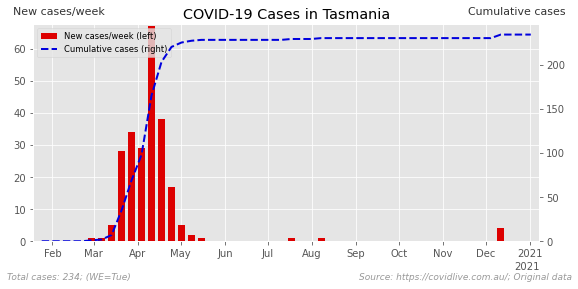

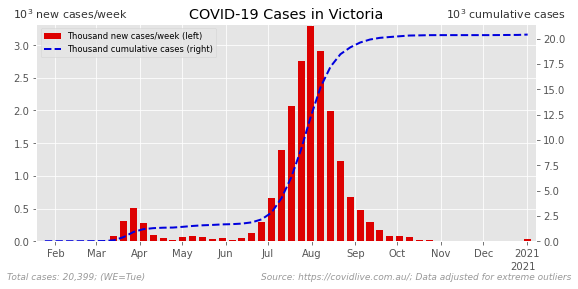

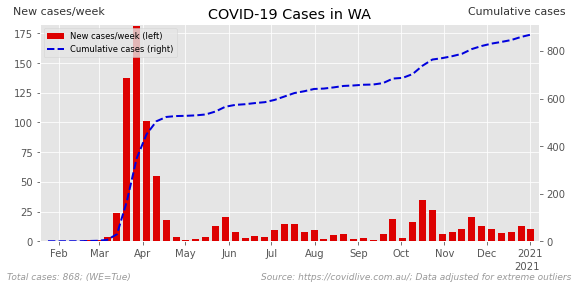

In [7]:
# weekly plot of case data
# plot annotation
quality = pd.Series(dtype=str)
for state in cases_daily_u.columns:
    if (cases_daily_u[state] == cases_daily_c[state]).all():
        quality[state] = f'{source}; Original data'
    else:
        quality[state] = f'{source}; Data adjusted for extreme outliers'
        
# call plotting function
_ = ps.plot_weekly(cases_daily_c, "cases", quality, 
                   chart_directory=CHART_DIRECTORY,
                   save_tag='weekly-covidlive',
                   show=True,
                  )

## Total deaths - weekly charts

In [8]:
# extract and transform case data
deaths_cum_u = frame_data.pivot(index='REPORT_DATE', columns='NAME', values='DEATH_CNT')
deaths_cum_u.index = pd.DatetimeIndex(deaths_cum_u.index)
if deaths_cum_u.iloc[-1].isna().any():
    deaths_cum_u = deaths_cum_u[:-1]
deaths_daily_u, deaths_daily_c, deaths_cum_c = (
    ps.dataframe_correction(deaths_cum_u, verbose=False))

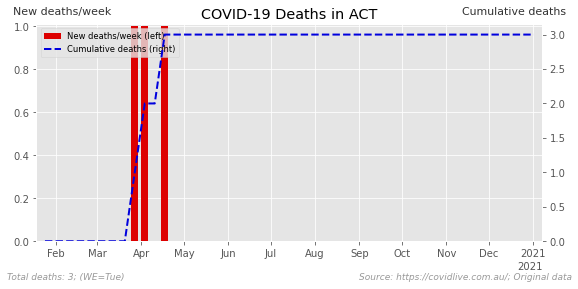

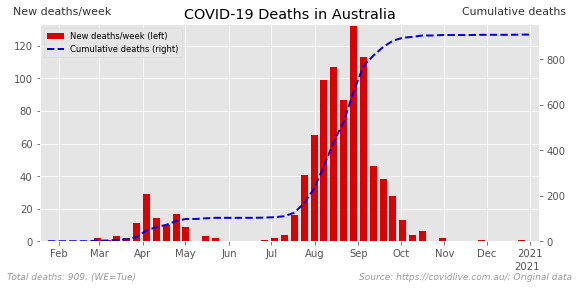

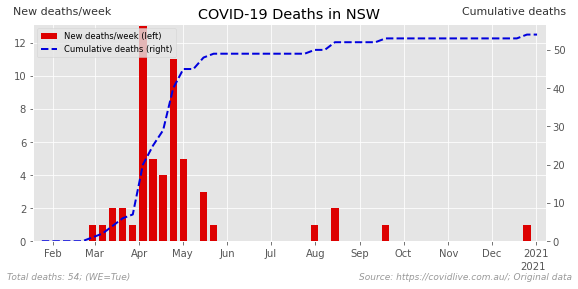

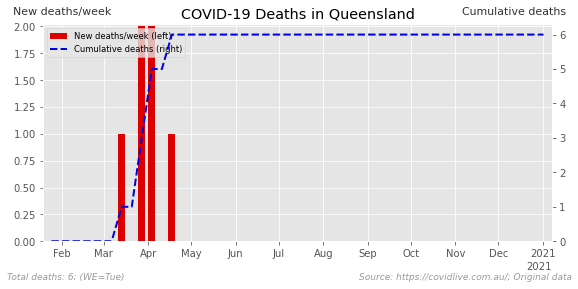

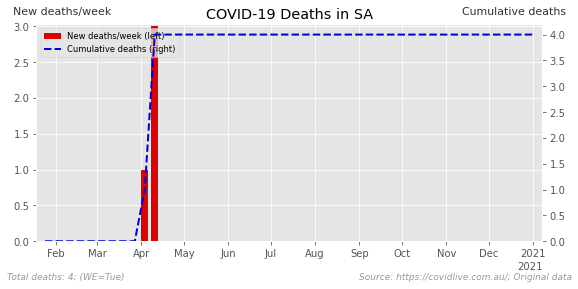

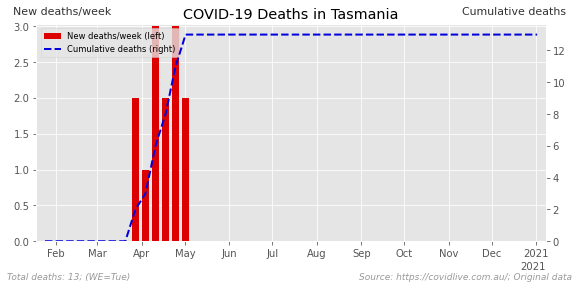

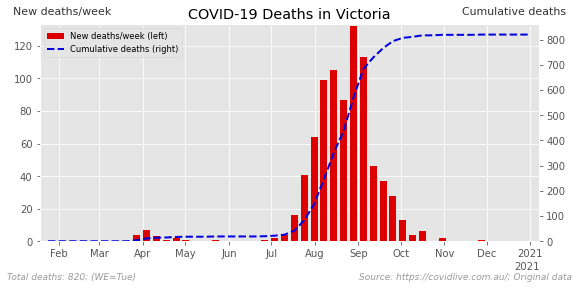

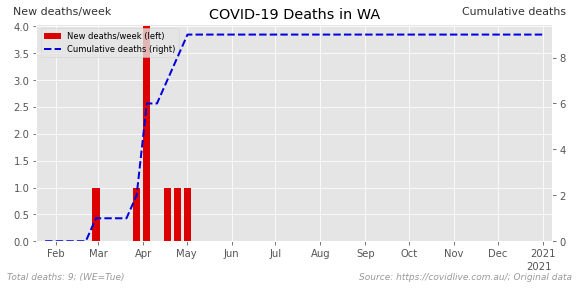

In [9]:
# weekly plot of deaths data
# plot annotation
quality = pd.Series(dtype=str)
for state in cases_daily_u.columns:
    if (deaths_daily_u[state] == deaths_daily_c[state]).all():
        quality[state] = f'{source}; Original data'
    else:
        quality[state] = f'{source}; Data adjusted for extreme outliers'
        
# call plotting function
_ = ps.plot_weekly(deaths_daily_c, "deaths", quality, 
                   chart_directory=CHART_DIRECTORY,
                   save_tag='weekly-covidlive',
                   show=True,
                  )

## Active Cases

In [10]:
colors = ['#ef4444', '#faa31b', '#eee000', '#82c341',
          '#009f75', 'dodgerblue', '#394ba0', '#d54799']  
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

In [11]:
active_all = frame_data.pivot(index='REPORT_DATE', columns='NAME', values='ACTIVE_CNT')
active_all.index = pd.DatetimeIndex(active_all.index)
active_all = active_all.dropna(axis=0, how='all')

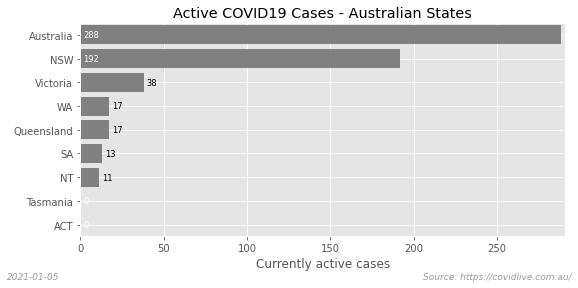

In [12]:
# bar chart of latest active cases
latest = active_all.copy()
if latest.iloc[-1].isna().any():
    latest = latest.iloc[:-1]
row = latest.iloc[-1].astype(int)
lfooter = str(row.name.date())
title = 'Active COVID19 Cases - Australian States'
ps.plot_barh(row.sort_values(ascending=True), 
    title=title,
    xlabel='Currently active cases',
    save_as = f'{CHART_DIRECTORY}{title}.png',
    rfooter=source,
    lfooter=lfooter,
    show=True,
)

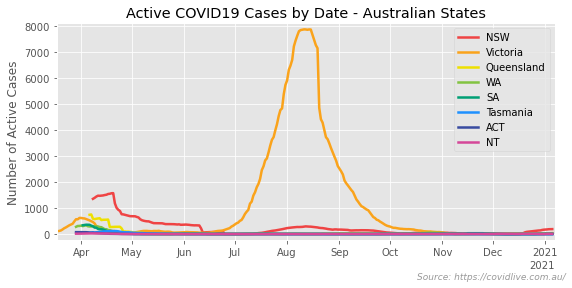

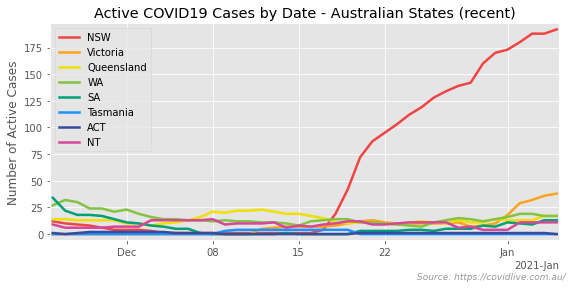

In [13]:
# line plots of trajectories
if 'Australia' in active_all.columns:
    del active_all['Australia']
order = ['NSW', 'Victoria', 'Queensland', 'WA', 'SA', 'Tasmania', 'ACT', 'NT']
title = 'Active COVID19 Cases by Date - Australian States'
RECENT = 42 # days
MARGINS = (0.005, 0.03)
for recent in [0, RECENT]:
    data = active_all.iloc[-recent:]

    fig, ax = plt.subplots()
    ax.xaxis_date()
    for state in order:
        ax.plot(active_all.index[-recent:].values, 
            active_all[state].iloc[-recent:], 
            label=state, lw=2.5)
    ax.margins(*MARGINS)
    ax.legend(loc='best')
    title_extra = ''
    if recent > 0:
        title_extra = ' (recent)'
    
    ps.finalise_plot(ax, title=title+title_extra, 
                     xlabel=None,
                     chart_directory=CHART_DIRECTORY,
                     ylabel='Number of Active Cases',
                     rfooter=source,
                     show=True,
                    )

## Source of infection

In [14]:
# build a dictionary if dataframes for infection source data
sources = ['SRC_OVERSEAS_CNT', 
           # 'SRC_SHIP_CNT', # seems to be zero
           'SRC_INTERSTATE_CNT', 'SRC_CONTACT_CNT', 'SRC_UNKNOWN_CNT',
           'SRC_INVES_CNT', 'REPORT_DATE']
names = {
    'SRC_OVERSEAS_CNT': 'Overseas',
    'SRC_INTERSTATE_CNT': 'Interstate',
    'SRC_CONTACT_CNT': 'Known contact',
    'SRC_UNKNOWN_CNT': 'Unknown contact',
    'SRC_INVES_CNT': 'Investigating',
}

state_SOI_data = {}
for state in frame_data.NAME.unique():
    df = frame_data[frame_data.NAME == state][sources]
    df.index = pd.DatetimeIndex(df.REPORT_DATE)
    del df['REPORT_DATE']
    df = df.dropna(axis=0, how='all') # remove empty rows
    if df.iloc[-1].isna().any():      # remove last row if partially complete
        df = df[:-1]
    df = df.rename(columns=names)
    state_SOI_data[state] = df

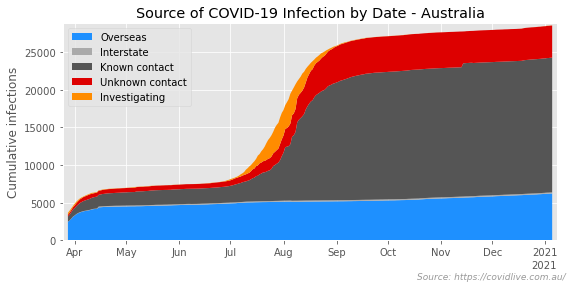

In [15]:
# plot national totals
serious = ['dodgerblue', '#aaaaaa', '#555555', '#dd0000', 'darkorange',]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=serious)
national_soi = state_SOI_data['Australia']
fig, ax = plt.subplots()
ax.stackplot(national_soi.index, 
             national_soi['Overseas'], 
             national_soi['Interstate'], 
             national_soi['Known contact'], 
             national_soi['Unknown contact'], 
             national_soi['Investigating'], 
             labels = ['Overseas', 'Interstate', 'Known contact', 
                       'Unknown contact', 'Investigating'])
ax.legend(loc='upper left')
ax.margins(0.01)

title = 'Source of COVID-19 Infection by Date - Australia'
ps.finalise_plot(ax, title=title, 
                 chart_directory=CHART_DIRECTORY,
                 xlabel=None, ylabel='Cumulative infections',
                 rfooter=source,
                 show=True,
                )

In [16]:
# extract the latest data, and under investigation
states = list(frame_data.NAME.unique())
states.remove('Australia')
latest = pd.DataFrame()
investigating = pd.DataFrame()
for state in states:
    df = state_SOI_data[state].sort_index()
    df = df.dropna(axis=0, how='all')
    investigating[state] = df['Investigating']
    latest[state] = df.iloc[-1]
    if latest[state].isna().any():
        print(f'Warning: data not current for {state}')
        print(latest[state][latest[state].isna()])
        warning_count += 1
        latest[state] = df.iloc[-2]
        
latest

,NSW,Victoria,Queensland,WA,SA,Tasmania,ACT,NT
Overseas,2821.0,1012.0,960.0,770.0,394.0,85.0,89.0,77.0
Interstate,90.0,0.0,23.0,7.0,13.0,3.0,3.0,2.0
Known contact,1617.0,15615.0,238.0,79.0,165.0,141.0,25.0,2.0
Unknown contact,435.0,3762.0,41.0,13.0,9.0,5.0,1.0,0.0
Investigating,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0


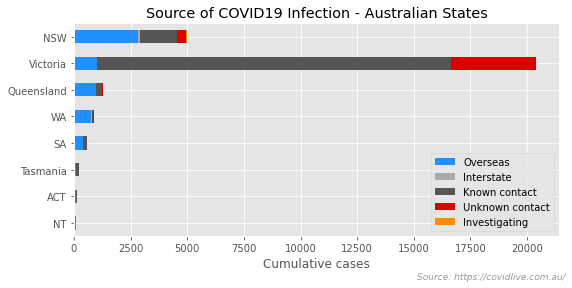

In [17]:
# plot the latest data
serious = ['dodgerblue', '#aaaaaa', '#555555', '#dd0000', 'darkorange',]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=serious)
ax = latest.T[::-1].plot.barh(stacked=True)
title = 'Source of COVID19 Infection - Australian States'
ps.finalise_plot(ax, title=title, 
                 chart_directory=CHART_DIRECTORY,
                 xlabel='Cumulative cases', ylabel=None,
                 rfooter=source,
                 show=True,
                )

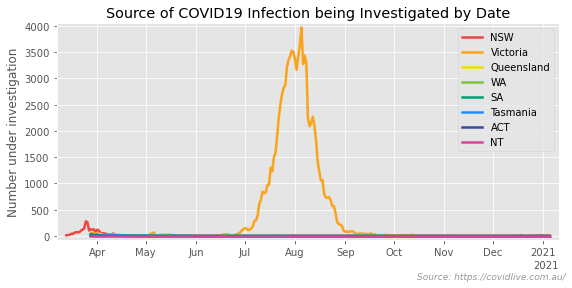

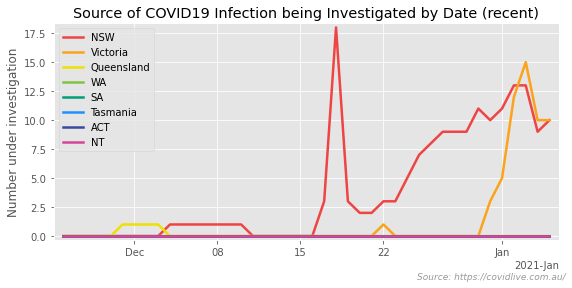

In [18]:
# plot under investigation
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
RECENT = 42
for recent in [0, RECENT]:
    fig, ax = plt.subplots()
    ax.margins(0.02)
    for state in investigating.columns:
        ax.plot(investigating.index[-recent:],
                investigating[state].iloc[-recent:],
                lw=2.5, label=state)
    ax.legend(loc='best')
    title = 'Source of COVID19 Infection being Investigated by Date'
    plus = ''
    if recent > 0:
        plus = ' (recent)'

    ps.finalise_plot(ax, 
                     title=title+plus, 
                     chart_directory=CHART_DIRECTORY,
                     xlabel=None, ylabel='Number under investigation',
                     rfooter=source,
                     show=True,
                    )

In [19]:
# Historic May, June, July 2020
if False: # switch
    
    YEAR = 2020
    MARGINS = (0.005, 0.03)
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
    for month in 5, 6, 7:
        history = investigating.loc[
                            (investigating.index.month == month) &
                            (investigating.index.year == YEAR)
                        ]
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(*MARGINS)
        for state in history.columns:
            ax.plot(history.index.values, history[state], label=state, lw=2.5)
        ax.legend(loc='best')

        title = ('Source of COVID19 Infection - Investigating Source by Date'
                 f' ({months[month]} {YEAR})')
        ps.finalise_plot(ax, title=title, 
                         chart_directory=CHART_DIRECTORY,
                         xlabel=None, ylabel='Number under investigation',
                         rfooter=source,
                         show=True,
                        )

In [20]:
# Historic - NSW in July, August and September 2020
if False: # switch - turn on/off this code block
    
    state = 'NSW'
    YEAR = 2020
    monthset = [7, 8, 9]
    mtext = ', '.join(map(lambda x: months[x], monthset))
    history = investigating.loc[
                                (investigating.index.month.isin(monthset)) &
                                (investigating.index.year == YEAR) 
                             ][state]
    MARGINS = 0.01
    fig, ax = plt.subplots()
    ax.xaxis_date()
    ax.margins(MARGINS) # seems to work here
        
    ax.plot(history.index.values, history, color='#dd0000')
    title = (f'Source of Infection under investigation in {state} '
             f' ({mtext} {YEAR})')

    ps.finalise_plot(ax, 
                     title=title, 
                     chart_directory=CHART_DIRECTORY,
                     xlabel=None,
                     ylabel='Cases under investigation',
                     rfooter=source,
                     show=True,
                    )

## Local cases - speculative 
Note: calculated using the source of infection data

### Calculate and plot local transmission from SOI data

In [21]:
local = ['Known contact', 'Unknown contact', 'Investigating']
local_lfooter = f'Local = {" + ".join(local)}'

def recent_bar_with_ma_plot(df, mode):
    """plotting function - bar charts for daily local transmission,
       with 7 and 14 day moving averages."""
    
    RECENT = 42 # days
    MA1 = 7 # days
    MA2 = 14 # dats
    plt.style.use('ggplot')
    
    for col in df.columns:
        series = df[col]
        
        if series.iloc[-RECENT:].sum() <= 0: 
            continue
        ma1 = series.rolling(MA1).mean()
        ma2 = series.rolling(MA2).mean()
        
        MARGINS = 0.01
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(MARGINS) # seems to work here
        
        ax.bar(series.iloc[-RECENT:].index.values, series.iloc[-RECENT:], label=mode, color='#dd0000')
        ax.plot(ma1.iloc[-RECENT:].index.values, ma1.iloc[-RECENT:], label=f'{MA1} day ave.', color='darkorange')
        ax.plot(ma2.iloc[-RECENT:].index.values, ma2.iloc[-RECENT:], label=f'{MA2} day ave.', color='cornflowerblue')
        ax.legend(loc='best')

        title = f'New Locally Acquired COVID19 {mode.title()} in {col} - Recent'
        ps.finalise_plot(ax, 
                         title=title, 
                         chart_directory=CHART_DIRECTORY,
                         xlabel=None,
                         ylabel=f'Daily New {mode.title()}',
                         lfooter=local_lfooter,
                         rfooter=source,
                         show=True,
                        )

In [22]:
# collect local transmission in a dictionary
local_trans = {}
for state in state_SOI_data:
    local_trans[state] = state_SOI_data[state][local].sum(axis=1, skipna=True)
    if state_SOI_data[state][local].iloc[-1].isna().any():
        local_trans[state].iloc[-1] = np.nan
        
# make a dataframe
local_trans_cum = (pd.DataFrame(local_trans)
                   .sort_index()
                   .dropna(axis=0, how='all')
                  )

# remove zero rows
dropable = local_trans_cum.sum(axis=1) == 0
local_trans_cum = local_trans_cum.loc[~dropable]

print('Last three days of raw cumulative data')
display(local_trans_cum.iloc[-3:])

# remove last row if contains ALL NANs
if local_trans_cum.iloc[-1].eq(0).any():
    local_trans_cum.iloc[-1] = (local_trans_cum.iloc[-1]
                                .where(local_trans_cum.iloc[-1].ne(0), 
                                       other=np.nan))
if local_trans_cum.iloc[-1].isna().any():
    local_trans_cum['Australia'].iloc[-1] = np.nan
if local_trans_cum.iloc[-1].isna().all():
    local_trans_cum = local_trans_cum[:-1]

# calculate local daily transmission, 
local_daily_raw = local_trans_cum.diff()

# look at last seven days
print('Local daily raw - past week')
local_daily_raw[-7:]

Last three days of raw cumulative data


,Australia,NSW,Victoria,Queensland,WA,SA,Tasmania,ACT,NT
REPORT_DATE,,,,,,,,,
2021-01-03,22158.0,2058.0,19381.0,279.0,92.0,174.0,146.0,26.0,2.0
2021-01-04,22161.0,2058.0,19384.0,279.0,92.0,174.0,146.0,26.0,2.0
2021-01-05,22168.0,2062.0,19387.0,279.0,92.0,174.0,146.0,26.0,2.0


Local daily raw - past week


,Australia,NSW,Victoria,Queensland,WA,SA,Tasmania,ACT,NT
REPORT_DATE,,,,,,,,,
2020-12-30,18.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31,13.0,10.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01,8.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02,18.0,7.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-01-03,10.0,8.0,3.0,-1.0,0.0,0.0,0.0,0.0,0.0
2021-01-04,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,7.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# More data transformation
# Manipulate the data for negative adjustments

mask = local_daily_raw.isna()

# and adjust for negatives
local_daily_cooked = pd.DataFrame()
for col in local_daily_raw.columns:
    # some local series start in March or
    # April and can start with negative 
    # corrections, which we remove here.
    fix = local_daily_raw[col].cumsum()
    fix = fix.where(fix < 0, other=0) * -1
    fixed = local_daily_raw[col] + fix
    # And also do our normal negative 
    # adjustments as well. 
    local_daily_cooked[col] = (
        ps.negative_correct_daily(fixed, verbose=False))
    
# avoid mid-update problems
local_daily_cooked = (local_daily_cooked
                      .where(~mask, other=np.nan))

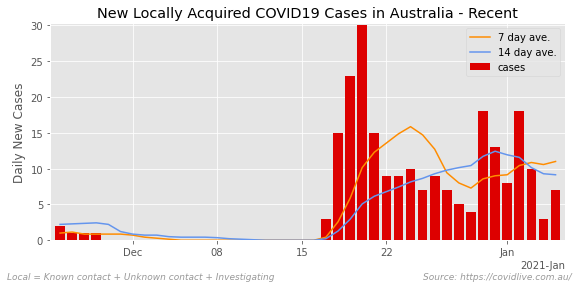

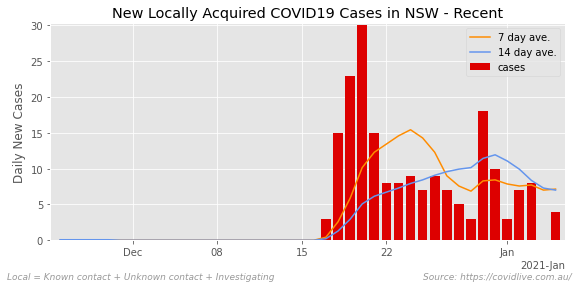

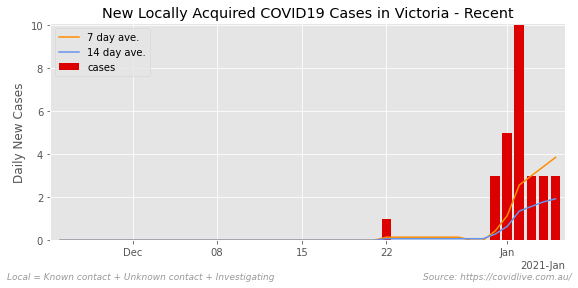

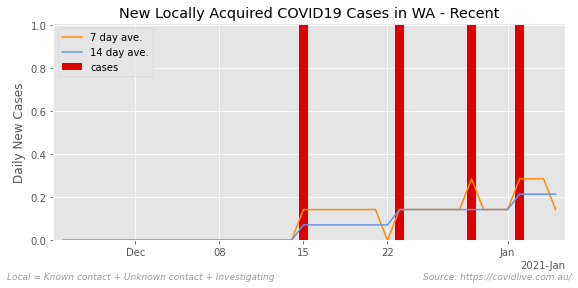

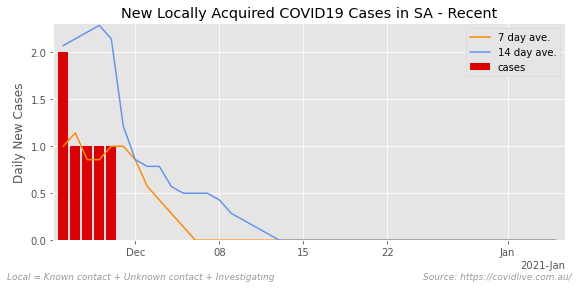

In [24]:
# and plot it
recent_bar_with_ma_plot(local_daily_cooked, "cases")

### Historical local cases charts

In [25]:
### Historic local daily in Vic in May, June and July 2020
# Also NSW in December 2020
if False: # switch - turn on/off this code block

    YEAR = 2020
    sets = [['Victoria', [5, 6, 7]],
            ['NSW', [12]]]

    for s in sets:
        state, monthset = s
        for month in monthset:
            history = local_daily_cooked.loc[
                        (local_daily_cooked.index.month == month) &
                        (local_daily_cooked.index.year == YEAR) 
                        ][state]

            MARGINS = 0.01
            fig, ax = plt.subplots()
            ax.xaxis_date()
            ax.margins(MARGINS) # seems to work here
        
            ax.bar(history.index.values, 
                   history, color='#dd0000')
            title = (f'New Locally Acquired COVID19 '
                     f'cases in {state} '
                     f'({months[month]} {YEAR})')

            ps.finalise_plot(ax, 
                             title=title, 
                             chart_directory=CHART_DIRECTORY,
                             xlabel=None,
                             ylabel='Daily New Cases',
                             lfooter=local_lfooter,
                             rfooter=source,
                             show=True,
                            )

In [26]:
# NSW in July, August and September 2020
if False: # switch - turn on/off this code block
    
    state = 'NSW'
    YEAR = 2020
    monthset = [7, 8, 9]
    mtext = ', '.join(map(lambda x: months[x], monthset))
    history = local_daily_cooked.loc[
                                (local_daily_cooked.index.month.isin(monthset)) &
                                (local_daily_cooked.index.year == YEAR) 
                             ][state]
    MARGINS = 0.01
    fig, ax = plt.subplots()
    ax.xaxis_date()
    ax.margins(MARGINS) # seems to work here
        
    ax.bar(history.index.values, history, color='#dd0000')
    title = (f'New Locally Acquired COVID19 Cases in {state}'
             f' ({mtext} {YEAR})')

    ps.finalise_plot(ax, 
                     title=title, 
                     chart_directory=CHART_DIRECTORY,
                     xlabel=None,
                     ylabel='Daily New Cases',
                     lfooter=local_lfooter,
                     rfooter=source,
                     show=True,
                    )

### Check consistency between cases data and SOI data
There appear to be some unexpected discrepancies here?

In [27]:
# row totals for source of infection data
soi_totals = {}
for state in state_SOI_data:
    soi_totals[state] = (state_SOI_data[state]
                         .dropna(axis=0, how='all')
                         .sum(axis=1, skipna=True))
soi_totals = pd.DataFrame(soi_totals)

# some adjustments for mid-update
if soi_totals.iloc[-1].isna().any():
    soi_totals['Australia'].iloc[-1] = np.nan
if soi_totals.iloc[-1].isna().all():
    soi_totals = soi_totals.iloc[:-1]

idx = cases_cum_u.index.intersection(soi_totals.index)
case_totals = cases_cum_u.loc[idx]

# compare and contrast
RECENT = 7
issues = {}
issues_recent = {}
differences = {}
for state in case_totals.columns:
    differences[state] = ((soi_totals[state].loc[idx]
                           - case_totals[state])
                          .sort_index())
    issues[state] = differences[state].ne(0).sum()
    issues_recent[state] = (differences[state]
                            .iloc[-RECENT:]
                            .ne(0).sum())

issue_report = pd.DataFrame([issues, issues_recent], 
                      index=['Total count of inconsistencies', 
                             'Inconsistencies in past '
                             f'{RECENT} days'])

diff_report = pd.DataFrame(differences)

print('Data inconsistencies - number of mismatch occurances')
display(issue_report)

print(f'Cumulative SOI minus Cumulative Cases in past {RECENT} days')
display(diff_report.iloc[-RECENT:])

Data inconsistencies - number of mismatch occurances


,ACT,Australia,NSW,NT,Queensland,SA,Tasmania,Victoria,WA
Total count of inconsistencies,63,98,48,65,63,63,98,62,62
Inconsistencies in past 7 days,0,0,0,0,0,0,0,0,0


Cumulative SOI minus Cumulative Cases in past 7 days


,ACT,Australia,NSW,NT,Queensland,SA,Tasmania,Victoria,WA
REPORT_DATE,,,,,,,,,
2020-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Hospitalised

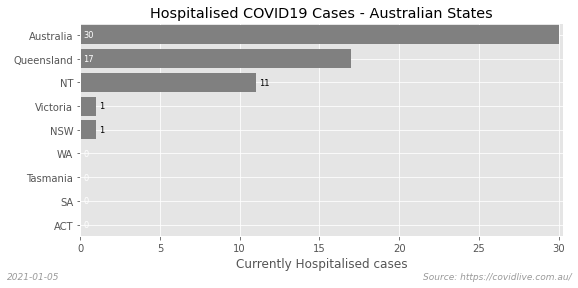

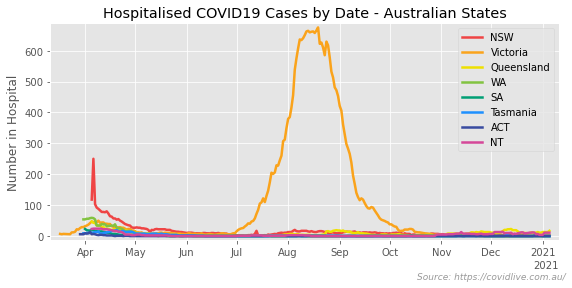

In [28]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
idents = ['MED_HOSP_CNT', 'MED_ICU_CNT', 'MED_VENT_CNT']
descs = ['Hospitalised', 'ICU', 'Ventilator']

for ident, desc in zip(idents, descs):

    hospital = frame_data.pivot(index='REPORT_DATE', columns='NAME', values=ident)
    hospital.index = pd.DatetimeIndex(hospital.index)
    hospital = hospital.dropna(axis=0, how='all')

    # bar chart of latest data
    latest = hospital.copy()
    if latest.iloc[-1].isna().any():
        latest = latest.iloc[:-1]
    row = latest.iloc[-1].astype(int)
    if row.sum() == 0:
        continue
    lfooter = str(row.name.date())
    title = f'{desc} COVID19 Cases - Australian States'
    ps.plot_barh(row.sort_values(ascending=True), 
                 title=title,
                 xlabel=f'Currently {desc} cases',
                 save_as = f'{CHART_DIRECTORY}{title}.png',
                 rfooter=source,
                 lfooter=lfooter,
                 show=True,
                )
    
    # plot hospitalised as a line chart
    if ident == 'MED_HOSP_CNT':
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(0.02)
        for state in order:
            ax.plot(hospital.index.values, hospital[state], label=state, lw=2.5)
        ax.legend(loc='best')

        title = 'Hospitalised COVID19 Cases by Date - Australian States'
        ps.finalise_plot(ax, 
                         title=title, 
                         chart_directory=CHART_DIRECTORY,
                         xlabel=None,
                         ylabel='Number in Hospital',
                         rfooter=source,
                         show=True,
                        )

## Tests

In [29]:
# Constants across all tests
state_pop = {
    # source: https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/latest-release
    # population at 30 June 2020
    'NSW': 8_164_100,
    'Victoria': 6_694_900,
    'Queensland': 5_174_400,
    'SA':  1_769_300,
    'WA':  2_661_900,
    'Tasmania':   540_600,
    'ACT':   431_100,
    'NT':    246_000,
}
power = 6
factor = 10 ** power
state_pop = pd.Series(state_pop) / factor

RECENT = 42 # days

In [30]:
# extract data
tests_all = frame_data.pivot(index='REPORT_DATE', columns='NAME', values='TEST_CNT')
tests_all.index = pd.DatetimeIndex(tests_all.index)
tests_all = tests_all.dropna(axis=0, how='all')

In [31]:
# adjust spikes / fix negative adjustments
tests_daily_u, tests_daily_c, tests_c = (
    ps.dataframe_correction(tests_all, verbose=False))

# indicate whether the recent data has been manipulated
lfooter_recent_testing = pd.Series(dtype=str)
for state in tests_daily_u:
    if (tests_daily_u[state].iloc[-RECENT:] ==
        tests_daily_c[state].iloc[-RECENT:]).all():
        lfooter_recent_testing[state] = 'Original data'
    else:
        lfooter_recent_testing[state] = (
            'Data adjusted for extreme outliers')

In [32]:
# if last row all zeros, ignore it
if tests_daily_c.iloc[-1].sum() == 0:
    tests_daily_c.drop(tests_daily_c.tail(1).index,inplace=True)

# check if we have test data from every state
if (tests_daily_c.iloc[-1] == 0).any():
    # Note: WA only reports tests on business days
    print("Warning: it's possible that not all test data is in")
    display(tests_daily_c[-7:])
    warning_count += 1

,ACT,Australia,NSW,NT,Queensland,SA,Tasmania,Victoria,WA
REPORT_DATE,,,,,,,,,
2020-12-30,592.0,40313.0,17267.0,469.0,4918.0,4929.0,597.0,8731.0,2810.0
2020-12-31,689.0,54719.0,27894.0,499.0,4796.0,4386.0,596.0,13097.0,2762.0
2021-01-01,574.0,56436.0,32010.0,389.0,5195.0,4533.0,627.0,13108.0,0.0
2021-01-02,538.0,60612.0,31864.0,347.0,3360.0,5967.0,199.0,18337.0,0.0
2021-01-03,773.0,51136.0,18923.0,190.0,2742.0,5543.0,488.0,22477.0,0.0
2021-01-04,780.0,77267.0,22275.0,410.0,6296.0,4606.0,493.0,32468.0,9939.0
2021-01-05,1064.0,80001.0,26391.0,0.0,13672.0,5877.0,453.0,32544.0,0.0


In [33]:
# Make zeros in the tail into NANs
# we are assuming every state does at least one test every day
cumsum = tests_daily_c.cumsum()
mask = ~((cumsum.eq(cumsum.iloc[-1], axis=1)) &
         (cumsum == cumsum.shift(1)))
tests_daily_c = tests_daily_c.where(mask, other=np.nan)

In [34]:
# remember un_normed tests
un_normed_tests = tests_daily_c.copy()

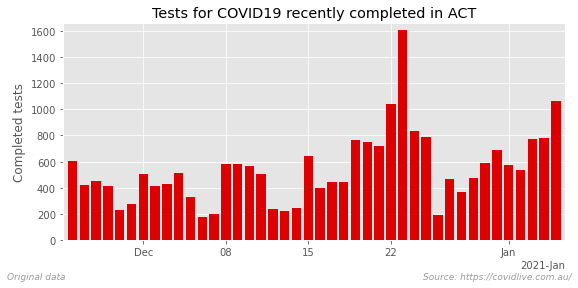

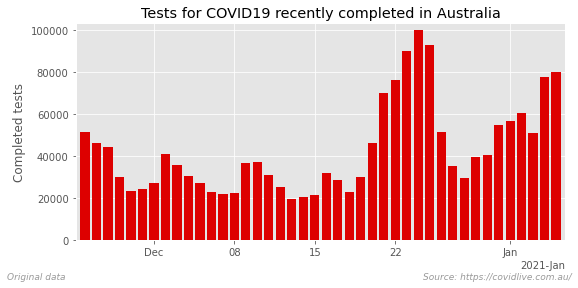

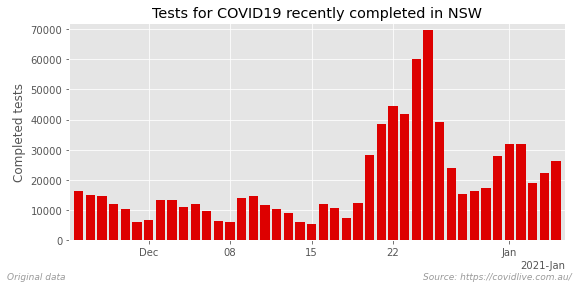

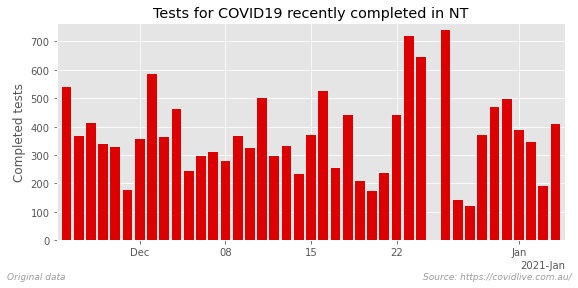

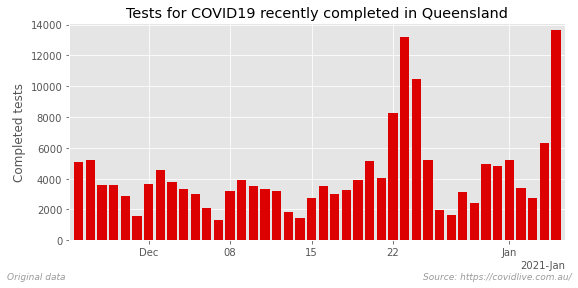

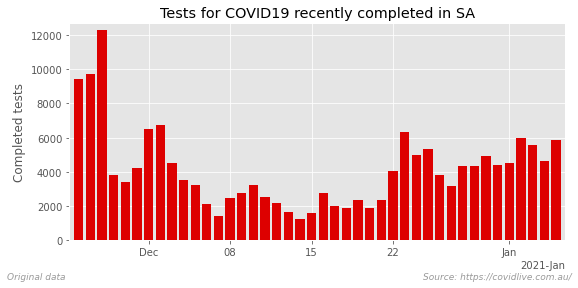

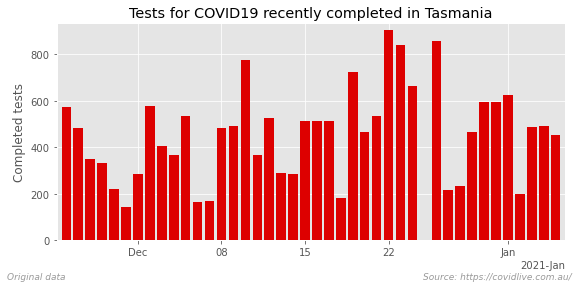

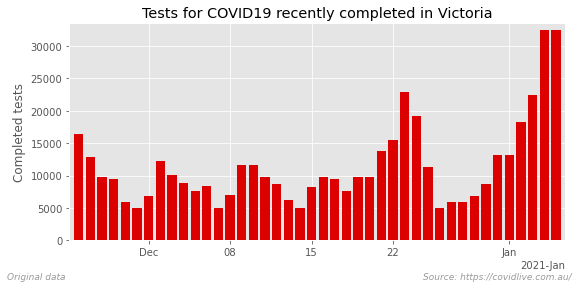

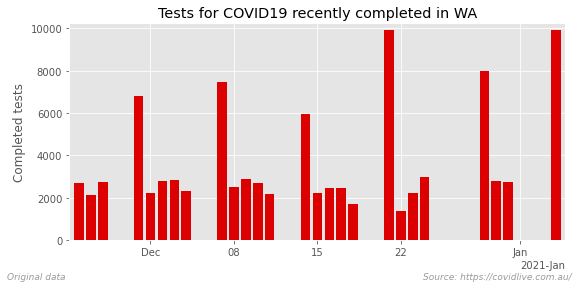

In [35]:
for state in un_normed_tests:
    
    test_data = un_normed_tests[state].iloc[-RECENT:].copy()
    
    fig, ax = plt.subplots()
    ax.xaxis_date()
    ax.margins(0.01, 0.03)
    ax.bar(test_data.index, test_data, color="#dd0000", width=0.8)
    title = f'Tests for COVID19 recently completed in {state}'
    ps.finalise_plot(ax, title=title, xlabel=None, 
                     chart_directory=CHART_DIRECTORY,
                     ylabel=f'Completed tests',
                     lfooter=lfooter_recent_testing[state],
                     rfooter=source,
                     show=True,
                    )    

In [36]:
ROLLING = 7
norm_tests_daily_c = (tests_daily_c / state_pop).rolling(ROLLING).mean()
norm_tests_daily_c = norm_tests_daily_c[list(state_pop.keys())]

In [37]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
MARGINS = 0.005, 0.03
for commencing in [0, -RECENT]: 
    fig, ax = plt.subplots()
    ax.xaxis_date()
    ax.margins(*MARGINS)
    for col in norm_tests_daily_c.columns:
        ax.plot(norm_tests_daily_c.iloc[commencing:][col].index,
                norm_tests_daily_c.iloc[commencing:][col],
                label=col, lw=2.5)
    ax.legend(loc='best')
    title = ('Tests per capita for COVID19 '
             f'({ROLLING}-day rolling ave)')
    if commencing != 0:
        title = title + ' - recent'

    ps.finalise_plot(ax, title=title, xlabel=None, 
                     chart_directory=CHART_DIRECTORY,
                     ylabel= 'Completed tests\n'
                             f'per $10^{power}$ population',
                     lfooter='Any extreme outliers have been adjusted',
                     rfooter=source,
                     #show=True,
                    )

In [38]:
# latest daily rolling average testing rates per million by state
norm_tests_daily_c.iloc[-7:].round(1)

,NSW,Victoria,Queensland,SA,WA,Tasmania,ACT,NT
REPORT_DATE,,,,,,,,
2020-12-30,4234.9,1341.3,818.5,2503.8,740.6,802.0,1231.7,1443.1
2020-12-31,3669.9,1210.5,662.5,2453.7,727.6,783.8,1183.4,1358.9
2021-01-01,3008.5,1247.6,662.2,2388.5,727.6,949.5,1113.4,1584.8
2021-01-02,2881.3,1534.2,701.3,2560.7,727.6,775.3,1229.1,1355.4
2021-01-03,2793.6,1889.0,732.4,2752.1,727.6,847.5,1329.5,1384.4
2021-01-04,2914.5,2456.4,820.5,2772.2,1261.0,915.9,1466.3,1552.8
2021-01-05,3090.6,3003.6,1131.4,2893.9,NaN,912.5,1660.2,NaN


In [39]:
# Victorian testing history
if False: # switch for this code block
    
    YEAR = 2020
    STATE = 'Victoria'
    MARGINS = 0.005, 0.03

    for month in 5, 6, 7:
    
        history = norm_tests_daily_c[
                (norm_tests_daily_c.index.year == YEAR) &
                (norm_tests_daily_c.index.month == month)
        ][STATE]
    
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(*MARGINS)
        ax.plot(history.index, history,
                label=STATE, lw=2.5, color='darkorange')
        ax.legend(loc='best')
        
        title = ('Tests for COVID19 in {STATE} '
                 f'({ROLLING} day rolling ave) '
                 f'({months[month]} {YEAR})')

        ps.finalise_plot(ax, title=title,
                         chart_directory=CHART_DIRECTORY,
                         xlabel=None, 
                         ylabel=f'Rate per $10^{power}$ population',
                         lfooter=lfooter_testing,
                         rfooter=source,
                         show=True,
                        )

## The End

In [40]:
print('Finished')

if warning_count:
    print(f'Check {warning_count} '
          f'warning{"s" if warning_count > 1 else ""} above')

Finished
Check 1 warning above
